#**Week15_복습과제_우정연**

##**8.10 텍스트 분석 실습 - 캐글 Mercari Price Suggestion Challenge**

- Mercari Price Suggestion Challenge
  - 일본의 대형 온라인 쇼핑몰인 Mercari사의 제품에 대해 가격을 예측하는 과제
  - 데이터 세트
    - 제품에 대한 여러 속성 및 제품 설명 등의 텍스트 데이터로 구성
    - 데이터를 기반으로 제품 예상 가격을 판매자들에게 제공
  - 판매자: 제품명, 브랜드 명, 카테고리, 제품 설명 등 다양한 속성 정보를 입력
  - ML 모델: 이 속성에 따라 제품의 예측 가격을 판매자에게 자동으로 제공

- 제공되는 데이터 세트의 속성
  - train_id: 데이터 id
  - name: 제품명
  - item_condition_id: 판매자가 제공하는 제품 상태
  - category_name: 카테고리 명
  - brand_name: 브랜드 명
  - **price**: 제품 가격, 예측 -> 예측해야 할 타깃 값
  - shipping: 배송비 무료 여부. 1이면 무료(판매자가 지불), 0이면 유료(구매자가 지불)
  - item_description: 제품에 대한 설명


###**[데이터 전처리]**

In [2]:
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import pandas as pd

from google.colab import drive
drive.mount('/content/drive')

mercari_df = pd.read_csv('drive/My Drive/Colab Notebooks/data/mercari_train.tsv', sep = '\t')
print(mercari_df.shape)
mercari_df.head(3)

Mounted at /content/drive
(1482535, 8)


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...


In [3]:
print(mercari_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 8 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   train_id           1482535 non-null  int64  
 1   name               1482535 non-null  object 
 2   item_condition_id  1482535 non-null  int64  
 3   category_name      1476208 non-null  object 
 4   brand_name         849853 non-null   object 
 5   price              1482535 non-null  float64
 6   shipping           1482535 non-null  int64  
 7   item_description   1482529 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 90.5+ MB
None


- brand_name: 많은 null 값을 가지고 있음

<ipython-input-4-dfe25bd8741b>:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train_df, kde = False)


<Axes: xlabel='price'>

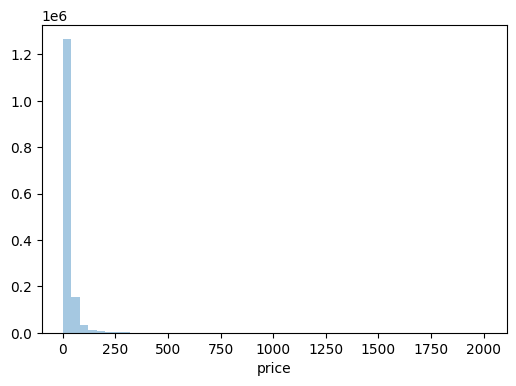

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

y_train_df = mercari_df['price']
plt.figure(figsize = (6,4))
sns.distplot(y_train_df, kde = False)

- price 값이 비교적 적은 가격을 가진 데이터 값에 왜곡되어 분포돼 있음. -> Price 칼럼을 로그 값으로 변환한 뒤 분포도 살피기

<ipython-input-5-dcfaed50b9ba>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train_df, kde = False)


<Axes: xlabel='price'>

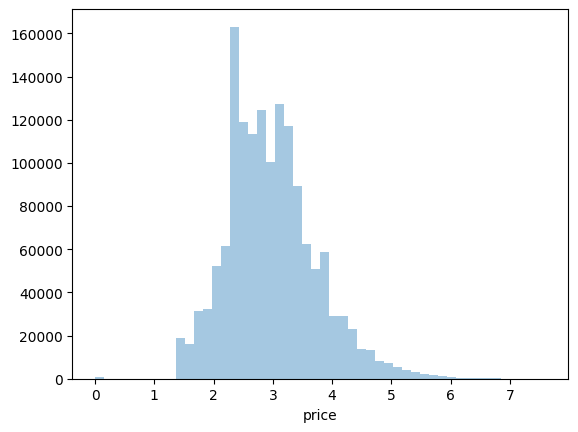

In [5]:
import numpy as np

y_train_df = np.log1p(y_train_df)
sns.distplot(y_train_df, kde = False)


- 비교적 정규 분포에 가까운 데이터를 이루게 됨.

In [6]:
mercari_df['price'] = np.log1p(mercari_df['price'])
mercari_df['price'].head(3)

,price
0,2.397895
1,3.970292
2,2.397895


In [7]:
print('Shipping 값 유형: \n', mercari_df['shipping'].value_counts())
print('item_condition_id 값 유형: \n', mercari_df['item_condition_id'].value_counts())


Shipping 값 유형: 
 shipping
0    819435
1    663100
Name: count, dtype: int64
item_condition_id 값 유형: 
 item_condition_id
1    640549
3    432161
2    375479
4     31962
5      2384
Name: count, dtype: int64


- Shipping 칼럼: 배송비 유무
  - 값이 비교적 균일
- Item_condition_id: 판매자가 제공하는 제품 상태
  - 1,2,3 값이 주를 이루고 있음
- item_description
  - Null 값은 별로 없지만, description에 대한 별도 설명이 없는 경우 'No description yet' 값으로 돼 있음

In [8]:
boolean_cond = mercari_df['item_description'] == 'No description yet'
mercari_df[boolean_cond]['item_description'].count()

82489

- No description yet 의 경우도 Null과 마찬가지로 의미있는 속성값으로 사용될 수 없으므로 적절한 값으로 변경해야 함

- category_name
  - '/'로 분리된 카테고리를 하나의 문자열로 나타냄
  - 텍스트이므로 피처 추출 시 tokenizer를 '/'로 하여 단어를 분리해 벡터화 가능
  - but '/'를 기준으로 단어를 토큰화해 각각 별도의 피처로 저장하고 이를 이용해 알고리즘을 학습
- `split_cat()` 함수를 생성하고 이를 DataFrame의 apply lambda 식에 적용
  - category_name이 Null이 아닌 경우 split('/')을 이용해 대, 중, 소 분류를 분리
  - category_name이 Null인 경우 split() 함수가 Error를 발생하므로 Error를 except catch하여 대, 중, 소 분류 모두 'Other Null' 값을 부여
- 판다스의 apply lambda로 반환되는 데이터 세트가 리스트를 요소로 가지고 있는데, 이를 다시 cat_dae, cat_jung, cat_so의 DataFrame 칼럼으로 분리해야 함.

In [9]:
# apply lambda에서 호출되는 대, 중, 소 분할 함수 생성, 대, 중, 소 값을 리스트로 반환
def split_cat(category_name):
  try:
    return category_name.split('/')
  except:
    return ['Other_Null', 'Other_Null', 'Other_Null']

# 위의 split_cat()을 apply lambda에서 호출해 대, 중, 소 칼럼을 mercari_df에 생성
mercari_df['cat_dae'], mercari_df['cat_jung'], mercari_df['cat_so'] = zip(*mercari_df['category_name'].apply(lambda x : split_cat(x)))

# 대분류만 값의 유형과 건수를 살펴보고, 중분류, 소분류는 값의 유형이 많으므로 분류 개수만 추출
print('대분류 유형: \n', mercari_df['cat_dae'].value_counts())
print('중분류 개수: ', mercari_df['cat_jung'].nunique())
print('소분류 개수: ', mercari_df['cat_so'].nunique())

대분류 유형: 
 cat_dae
Women                     664385
Beauty                    207828
Kids                      171689
Electronics               122690
Men                        93680
Home                       67871
Vintage & Collectibles     46530
Other                      45351
Handmade                   30842
Sports & Outdoors          25342
Other_Null                  6327
Name: count, dtype: int64
중분류 개수:  114
소분류 개수:  871


- brand_name, category_name, item_description 칼럼의 Null 값은 일괄적으로 'Other Null'로 동일하게 변경
  - `fillna()`를 적용한 뒤 각 칼럼별로 Null 값이 없는지 `mercari_df.isnull().sum()`을 호출해 확인

In [10]:
mercari_df['brand_name'] = mercari_df['brand_name'].fillna(value = 'Other_Null')
mercari_df['category_name'] = mercari_df['category_name'].fillna(value = 'Other_Null')
mercari_df['item_description'] = mercari_df['item_description'].fillna(value = 'Other_Null')

# 각 칼럼별로 Null 값 건수 확인, 모두 0이 나와야 함
mercari_df.isnull().sum()

,0
train_id,0
name,0
item_condition_id,0
category_name,0
brand_name,0
price,0
shipping,0
item_description,0
cat_dae,0
cat_jung,0


###**[피처 인코딩과 피처 벡터화]**

- Mercari Price Suggestion 데이터 세트는 문자열 칼럼이 많음
  - 문자열 칼럼 중 레이블 또는 원-핫 인코딩을 수행하거나 피처 벡터화로 변환할 칼럼 선별
  1. 피처를 어떤 방식으로 변환할지 검토
  2. 일괄적으로 전체 속성의 변환 작업 적용
  - 상품 가격을 예측해야 하므로 회귀 모델을 기반으로 함
    - 선형 회귀 모델과 회귀 트리 모델을 모두 적용
    - 선형 회귀의 경우 원-핫 인코딩 적용이 훨씬 선호되므로 인코딩할 피처는 모두 원-핫 인코딩 적용
    - 피처 벡터화의 경우 비교적 짧은 텍스트의 경우 Count 기반 벡터화, 긴 텍스트는 TF-IDF 기반의 벡터화 적용



1. brand_name 칼럼 검토
  - 상품의 브랜드명

In [11]:
print('brand name의 유형 건수:', mercari_df['brand_name'].nunique())
print('brand name sample 5건: \n', mercari_df['brand_name'].value_counts()[:5])

brand name의 유형 건수: 4810
brand name sample 5건: 
 brand_name
Other_Null           632682
PINK                  54088
Nike                  54043
Victoria's Secret     48036
LuLaRoe               31024
Name: count, dtype: int64


  - 대부분 명료한 문자열로 돼 있음
    - 별도의 피처 벡터화 형태로 만들 필요 없이 인코딩 변환을 적용
    - 원-핫 인코딩 변환


2. name 속성 검토
  - 상품명

In [12]:
print('name의 종류 개수:', mercari_df['name'].nunique())
print('name sample 10건: \n', mercari_df['name'][:10])

name의 종류 개수: 1225273
name sample 10건: 
 0       MLB Cincinnati Reds T Shirt Size XL
1          Razer BlackWidow Chroma Keyboard
2                            AVA-VIV Blouse
3                     Leather Horse Statues
4                      24K GOLD plated rose
5          Bundled items requested for Ruie
6        Acacia pacific tides santorini top
7      Girls cheer and tumbling bundle of 7
8                     Girls Nike Pro shorts
9    Porcelain clown doll checker pants VTG
Name: name, dtype: object


- name 속성
  - 종류가 매우 많음
  - 개별적으로 거의 고유한 상품명을 가지고 있음
  - 유형이 매우 많고, 적은 단어 위주의 텍스트 형태
   - count 기반으로 피처 벡터화 변환 적용
- category_name
  - cat_dae, cat_jung, cat_so 원-핫 인코딩 적용
- shipping
  - 배송비 무료 여부. 0,1 값을 가짐
  - 원-핫 인코딩 적용
- item_description
  - 상품에 대한 간단 설명. 데이터 세트에서 가장 긴 텍스트 가짐


In [13]:
pd.set_option('max_colwidth', 200)

# item_description의 평균 문자열 크기
print('item_description 평균 문자열 크기: ', mercari_df['item_description'].str.len().mean())

mercari_df['item_description'][:2]

item_description 평균 문자열 크기:  145.71139703278507


,item_description
0,No description yet
1,This keyboard is in great condition and works like it came out of the box. All of the ports are tested and work perfectly. The lights are customizable via the Razer Synapse app on your PC.


- item_description
  - 평균 문자열이 145자로 비교적 크므로 해당 칼럼은 TF-IDF로 변환
- 주요 칼럼을 인코딩 및 피처 벡터화 변환
  - name: `CounterVectorizer` 변환
  - item_description: `TfidfVectorizer` 변환

In [14]:
# name 속성에 대한 피처 벡터화 변환
cnt_vec = CountVectorizer()
X_name = cnt_vec.fit_transform(mercari_df.name)

# item_description에 대한 피처 벡터화 변환
tfidf_descp = TfidfVectorizer(max_features = 50000, ngram_range = (1, 3), stop_words = 'english')
X_descp = tfidf_descp.fit_transform(mercari_df['item_description'])

print('name vectorization shape:', X_name.shape)
print('item_description vectorization shape:', X_descp.shape)

name vectorization shape: (1482535, 105757)
item_description vectorization shape: (1482535, 50000)


- CountVectorizer, TfidfVectorizer가 `fit_trainsform()`을 통해 반환하는 데이터는 희소 행렬 형태
  - 희소 행렬 객체 변수인 X_name과 X_descp를 새로 결합해 새로운 데이터 세트로 구성해야
  - 앞으로 인코딩 될 cat_dae, cat_jung, cat_so, brand_name, shipping, item_condition_id도 모두 X_name, X_descp와 결합돼 ML 모델을 실행하는 기반 데이터 세트로 재구성돼야 함
    - 이를 위해 이 인코딩 대상 칼럼도 밀집 행렬 형태가 아닌 희소 행렬 형태로 인코딩을 적용한 뒤, 함께 결합

- 사이킷런의 OneHotEncoder, LabelBinarizer 클래스
  - LabelBinarizer 클래스: 희소 행렬 형태의 원-핫 인코딩 변환을 지원
    - 생성 시 `sparse_out = True`로 파라미터를 설정해주면 됨
    - 모든 인코딩 대상 칼럼은 LabelBinarizer를 이용해 희소 행렬 형태의 원-핫 인코딩으로 변환
  - 개별 칼럼으로 만들어진 희소 행렬은 사이파이 패키지 sparse 모듈의 `hstack()` 함수를 이용해 결합
    - `hstack()` 함수: 희소 행렬을 손쉽게 칼럼 레벨로 결합할 수 있게 해줌
    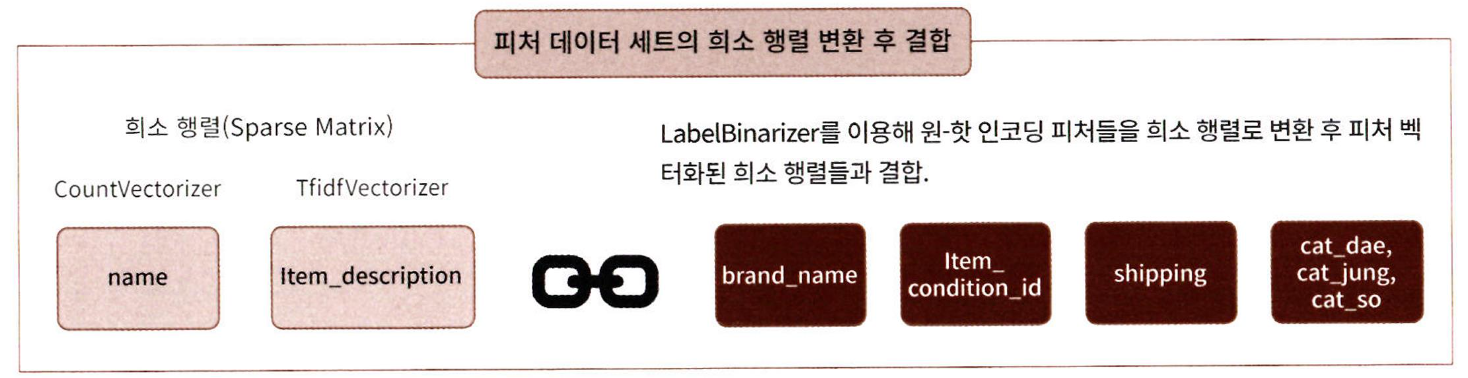

In [15]:
from sklearn.preprocessing import LabelBinarizer

# brand_name, item_condition_id, shipping 각 피처들을 희소 행렬 원-핫 인코딩 변환
lb_brand_name = LabelBinarizer(sparse_output = True)
X_brand = lb_brand_name.fit_transform(mercari_df['brand_name'])
lb_item_cond_id = LabelBinarizer(sparse_output = True)
X_item_cond_id = lb_item_cond_id.fit_transform(mercari_df['item_condition_id'])
lb_shipping = LabelBinarizer(sparse_output = True)
X_shipping = lb_shipping.fit_transform(mercari_df['shipping'])

# cat_dae, cat_jung, cat_so 각 피처들을 희소 행렬 원-핫 인코딩 변환
lb_cat_dae = LabelBinarizer(sparse_output = True)
X_cat_dae = lb_cat_dae.fit_transform(mercari_df['cat_dae'])
lb_cat_jung = LabelBinarizer(sparse_output = True)
X_cat_jung = lb_cat_jung.fit_transform(mercari_df['cat_jung'])
lb_cat_so = LabelBinarizer(sparse_output = True)
X_cat_so = lb_cat_so.fit_transform(mercari_df['cat_so'])

print(type(X_brand), type(X_item_cond_id), type(X_shipping))
print('X_brand shape:{0}, X_item_cond_id shape:{1}'.format(X_brand.shape, X_item_cond_id.shape))
print('X_shipping shape:{0}, X_cat_dae shape:{1}'.format(X_shipping.shape, X_cat_dae.shape))
print('X_cat_jung shape:{0}, X_cat_so shape:{1}'.format(X_cat_jung.shape, X_cat_so.shape))

<class 'scipy.sparse._csr.csr_matrix'> <class 'scipy.sparse._csr.csr_matrix'> <class 'scipy.sparse._csr.csr_matrix'>
X_brand shape:(1482535, 4810), X_item_cond_id shape:(1482535, 5)
X_shipping shape:(1482535, 1), X_cat_dae shape:(1482535, 11)
X_cat_jung shape:(1482535, 114), X_cat_so shape:(1482535, 871)


- 인코딩 변환된 데이터 세트가 CSR 형태로 변환된 csr_matrix 타입임
- brand_name 칼럼
  - 값의 유형이 4810개이므로 이를 원-핫 인코딩 변환한 X_brand_shape의 경우 4810개의 인코딩 칼럼을 가지게 됨
- X_cat_so의 경우도 마찬가지로 871개의 인코딩 칼럼
- 인코딩 칼럼이 매우 많이 생겼지만, 피처 벡터화로 텍스트 형태의 문자열이 가지는 벡터 형태의 매우 많은 칼럼과 함께 결합되므로 문제 될 것은 없음


- 피처 벡터화 변환한 데이터 세트와 희소 인코딩 변환된 데이터 세트를 `hstack()`을 이용해 모두 결합
- 결합된 데이터는 Mercari Price Suggestion을 위한 기반 데이터 세트로 사용
  - 결합한 데이터의 타입과 크기만 확인하고 메모리에서 삭제
  - 만들어진 결합 데이터가 많은 메모리를 잡아먹어 개인용 PC에서 메모리 오류 발생 가능하므로
    - del '객체 변수명'과 `gc.collect()`로 결합 데이터를 메모리에서 삭제

In [16]:
from scipy.sparse import hstack
import gc

sparse_matrix_list = (X_name, X_descp, X_brand, X_item_cond_id,
                      X_shipping, X_cat_dae, X_cat_jung, X_cat_so)

# hstack 함수를 이용해 인코딩과 벡터화르 ㄹ수행한 데이터 세트를 모두 결합
X_features_sparse = hstack(sparse_matrix_list).tocsr()
print(type(X_features_sparse), X_features_sparse.shape)

# 데이터 세트가 메모리를 많이 차지하므로 사용 목적이 끝났으면 바로 메모리에서 삭제
del X_features_sparse
gc.collect()

<class 'scipy.sparse._csr.csr_matrix'> (1482535, 161569)


0

- hstack()으로 결합한 데이터 세트
  - csr_matrix 타입
  - 총 161569개의 피처를 가지게 됨

-> 회귀를 적용해 price 값을 예측할 수 있도록 모델 만들기

###**[릿지 회귀 모델 구축 및 평가]**

- 모델을 평가하는 평가(Evaluation) 로직의 함수화
  - RMSLE(Root Mean Square Logarithmic Error) 방식
    - RMSE와 유사하지만 오류 값에 로그를 취해 RMSE를 구하는 방식
    - 낮은 가격보다 높은 가격에서 오류가 발생할 경우 오류 값이 더 커지는 것 방지 위해 도입
  - RMSLE 구하는 별도의 함수 `rmsle((y, y_pred))` 생성
  - 주의 사항
    - 원본 데이터의 price 칼럼의 값은 왜곡된 데이터 분포를 가지고 있으므로 이를 정규 분포 형태로 유도하기 위해 로그 값을 취해 변환
    - 학습할 모델이 사용할 price 값은 로그 값으로 변환된 값이므로 예측도 당연히 로그로 변환한 데이터 값 수준의 price 값임
      - 학습 모델을 이용한 예측 price 값은 다시 로그의 역변환인 지수 (Exponential) 변환을 수행해 원복해야 함
      - 원복 데이터를 기반으로 RMSLE를 적용할 수 있도록 `evaluate_org_price(y_test, preds)` 함수 생성

In [17]:
def rmsle(y, y_pred):
  # underflow, overflow를 막기 위해 log가 아닌 log1p로 rmsle 계산
  return np.sqrt(np.mean(np.power(np.log1p(y) - np.log1p(y_pred), 2)))

def evaluate_org_price(y_test, preds):

  # 원본 데이터는 log1p로 변환되었으므로 exmpm1로 원복 필요
  preds_exmpm = np.expm1(preds)
  y_test_exmpm = np.expm1(y_test)

  # rmsle로 RMSLE 값 추출
  rmsle_result = rmsle(y_test_exmpm, preds_exmpm)
  return rmsle_result

import gc
from scipy.sparse import hstack

def model_train_predict(model, matrix_list):
  # scipy.sparse 모듈의 hstack을 이용해 희소 행렬 결합
  X = hstack(matrix_list).tocsr()

  X_train, X_test, y_train, y_test = train_test_split(X, mercari_df['price'],
                                                      test_size = 0.2, random_state = 156)

  # 모델 학습 및 예측
  model.fit(X_train, y_train)
  preds = model.predict(X_test)

  del X, X_train, X_test, y_train
  gc.collect()

  return preds, y_test

- Ridge를 이용한 Mercari Price의 회귀 예측 수행
- 수행 전, Mercari 상품 가격 예측에 item_description과 같은 텍스트 형태의 속성이 얼마나 영향을 미치는지 알아보기
  - item_description 속성의 피처 벡터화 데이터가 포함되지 않았을 때와 포함됐으 떄의 예측 성능을 비교

In [18]:
linear_model = Ridge(solver = 'lsqr', fit_intercept = False)

sparse_matrix_list = (X_name, X_brand, X_item_cond_id,
                      X_shipping, X_cat_dae, X_cat_jung, X_cat_so)
linear_preds, y_test = model_train_predict(model = linear_model, matrix_list = sparse_matrix_list)
print('Item Description을 제외했을 때 rmsle 값: ', evaluate_org_price(y_test, linear_preds))

sparse_matrix_list = (X_descp, X_name, X_brand, X_item_cond_id,
                      X_shipping, X_cat_dae, X_cat_jung, X_cat_so)
linear_preds, y_test = model_train_predict(model = linear_model, matrix_list = sparse_matrix_list)
print('Item Description을 포함한 rmsle 값: ', evaluate_org_price(y_test, linear_preds))

Item Description을 제외했을 때 rmsle 값:  0.4983990938999374
Item Description을 포함한 rmsle 값:  0.4680348033168731


- Item Description을 포함했을 때 rmsle 값이 많이 감소함
  -> Item Description 영향이 중요함

###**[LightGBM 회귀 모델 구축과 앙상블을 이용한 최종 예측 평가]**

- LightGBM을 이용해 회귀를 수행한 뒤, 위에서 구한 릿지 모델 예측값과 LightGBM 모델 예측값을 간단한 앙상블(Ensemble) 방식으로 섞어서 최종 회귀 예측값을 평가

In [19]:
from lightgbm import LGBMRegressor

sparse_matrix_list = (X_descp, X_name, X_brand, X_item_cond_id,
                      X_shipping, X_cat_dae, X_cat_jung, X_cat_so)
lgbm_model = LGBMRegressor(n_estimators=200, learning_rate = 0.5, num_leaves = 125, random_state = 156)
lgbm_preds, y_test = model_train_predict(model = lgbm_model, matrix_list = sparse_matrix_list)
print('LightGBM rmsle 값: ', evaluate_org_price(y_test, lgbm_preds))

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 3350.196285 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1068421
[LightGBM] [Info] Number of data points in the train set: 1186028, number of used features: 65338
[LightGBM] [Info] Start training from score 2.979514


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


LightGBM rmsle 값:  0.4569987654210569


- 앞 예제의 Ridge보다 예측 성능이 더 나아짐
- LightGBM의 예측 결과값과 위의 Ridge 예측 결과값을 서로 앙상블해 최종 예측 결과값 도출
  - (*LightGBM*)*0.45 + (Ridge)*0.55

In [20]:
preds = lgbm_preds * 0.45 + linear_preds * 0.55
print('LightGBM과 Ridge를 ensemble한 최종 rmsle 값:', evaluate_org_price(y_test, preds))

LightGBM과 Ridge를 ensemble한 최종 rmsle 값: 0.44693020572532727


- 간단한 앙상블 방식으로 예측 성능을 더 개선했음